In [1]:
# load functions for data analysis
from adapting_fyp_analysis import experimental, visualizeStats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy
import seaborn as sns
import numpy as np

% pylab inline
pandas.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_path = '/Users/biota/Desktop/sSL/experiment_2/collection/scr_data/'

In [3]:
day1 = experimental(data_path)
day1.day = 1
day1.keepEdgeBefore = 0 
day1.keepEdgeAfter = 0 
day1.loadData()

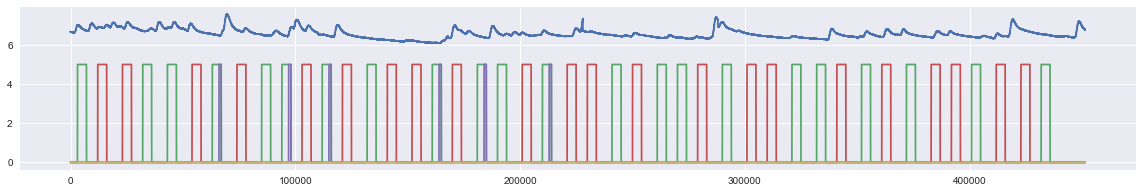

In [4]:
figure(figsize=[20,3])
plot(day1.rawData[0]); 

In [5]:
day1.preprocessData()

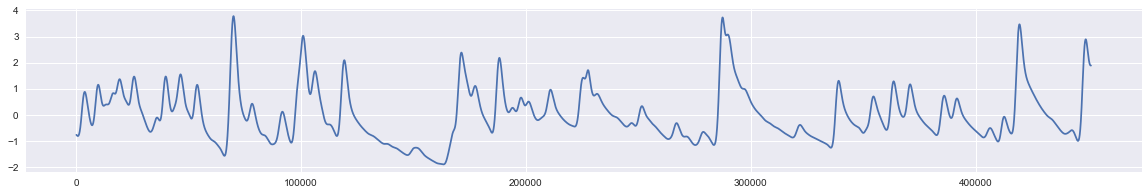

In [6]:
figure(figsize=[20,3])
plot(day1.transData[0][0]); 

In [240]:
day2 = experimental(data_path)
day2.day = 2
day2.preprocessData()

# find counterbalanced subjects

In [241]:
cb = []
bc = []

for i_subject in range(0,len(day2.subjectNames)): 
    
    condMarkers = np.copy(day2.transData[i_subject][1])
    pos_ons = day2.stimuli(condMarkers[:,0])[0]
    neg_ons = day2.stimuli(condMarkers[:,1])[0]
    
    if pos_ons[0] > neg_ons[0]: 
        cb.append(i_subject)
    else: 
        bc.append(i_subject)

cb = np.array(cb)
bc = np.array(bc)

In [242]:
iStim = 0
day2.nSeconds = 5
plus, minus = day1.amplitudeDifference('trans',iStim,'offset');

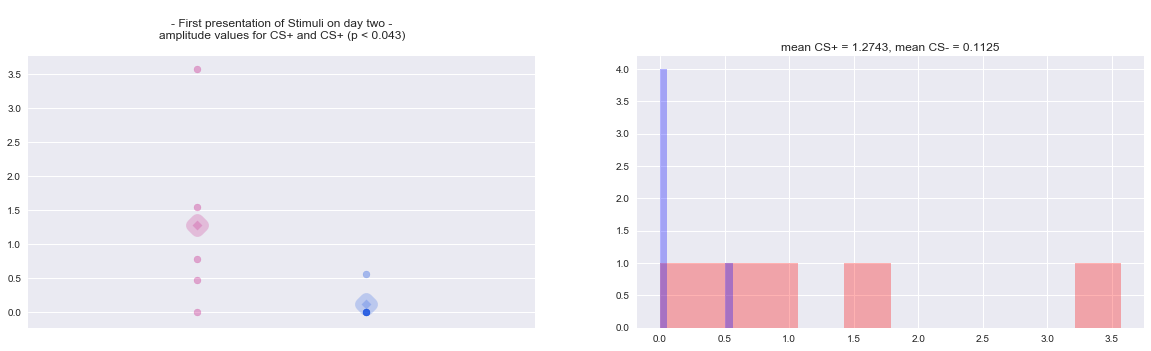

In [243]:
results = scipy.stats.wilcoxon(plus, minus);
visualizeStats(plus,minus,results, heading='First presentation of Stimuli on day two')

In [267]:
CSPs = np.zeros([day1.nSubjects,len(range(4,12))])
CSMs = np.zeros([day1.nSubjects,len(range(4,12))])

day1.nSeconds = 5
conditioning = list(range(4,12))
for iStim in range(0,len(conditioning)):
    CSPs[:,iStim], CSMs[:,iStim] = day1.amplitudeDifference('trans',conditioning[iStim],'offset');
    
conResultsS = np.zeros(day1.nSubjects)
for iSubject in range(0,day1.nSubjects): 
    conResultsS[iSubject] = scipy.stats.ttest_ind(log(1 + CSPs[iSubject,:]),log(1 + CSMs[iSubject,:]))[1];

conditionedSubjects = find(conResultsS<.05)

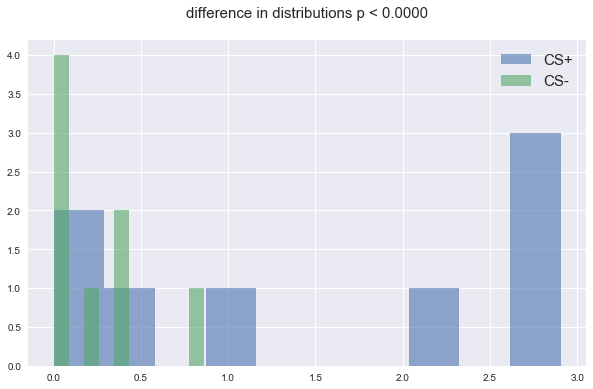

In [268]:
figure(figsize=[10,6])
hist(CSPs[0], label='CS+', alpha=.6)
hist(CSMs[0], label='CS-', alpha=.6)
legend(fontsize=15)
title('difference in distributions p < %.04f\n'%scipy.stats.wilcoxon(CSPs.flatten(),CSMs.flatten())[1], fontsize=15); 

In [269]:
wrongConditioned = find(mean(CSPs[conditionedSubjects,:] - CSMs[conditionedSubjects,:],1)<0)

In [271]:
sInd = 4
eInd = 13
CSP = np.zeros([day1.nSubjects,len(range(sInd,eInd))])
CSM = np.zeros([day1.nSubjects,len(range(sInd,eInd))])

day1.nSeconds = 4
conditioning = list(range(sInd,eInd))

for iStim in range(0,len(conditioning)):
    CSP[:,iStim], CSM[:,iStim] = day1.amplitudeDifference('trans',conditioning[iStim],'onset');
    
conResults = np.zeros(day1.nSubjects)

for iSubject in range(0,day1.nSubjects): 
    conResults[iSubject] = scipy.stats.wilcoxon(log(1+CSP[iSubject,:]),log(1+CSM[iSubject,:]))[1];

In [272]:
conResults

array([ 0.95276502,  0.26039294,  0.21352435,  0.76709687,  0.01086222])

In [273]:
def results_vary_p(p_value): 
    
    conditionedSubjects = find(conResults < p_value)

    cbSubs = 0 
    #for iSubject in conditionedSubjects: 
    #    if iSubject in cb: cbSubs = cbSubs + 1
    bcSubs = 0 
    #for iSubject in conditionedSubjects: 
    #    if iSubject in bc: bcSubs = bcSubs + 1
    print 'with a threshhold of p < ', p_value,'total subjects:', bcSubs + cbSubs, 'counterbalanced subjects:', cbSubs
    
    iStim = 0
    day2.nSeconds = 4.5
    plus, minus = day2.amplitudeDifference('raw',iStim,'onset');

    pConditioned = plus[conditionedSubjects]
    mConditioned = minus[conditionedSubjects]

    results = scipy.stats.wilcoxon(pConditioned, mConditioned)
    visualizeStats(pConditioned,mConditioned,results, 
                   heading='in participants with predictions on day 1 (p < %s)'%p_value)
    
#     for i_subject in range(day2.nSubjects): 
        
#         plt.annotate(day2.subjectNames[i_subject], xy=(np.ones(pConditioned), pConditioned),
#                      textcoords='offset points', alpha=.9, fontsize=10)

with a threshhold of p <  1 total subjects: 0 counterbalanced subjects: 0


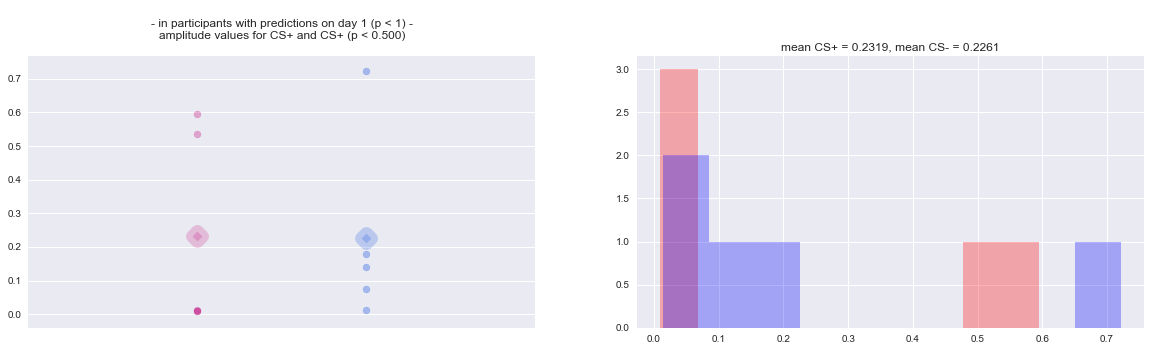

In [274]:
results_vary_p(1)

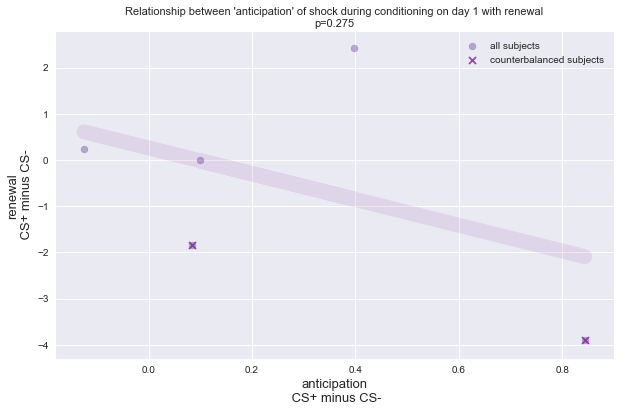

In [275]:
figure(figsize=(10,6))

iStim = 0
day2.nSeconds = 6
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');


var1 = mean(CSP - CSM,1)#[conditionedSubjects]
var2 =  plus - minus #plus[conditionedSubjects]-minus[conditionedSubjects]

tmp = smf.OLS(var2,var1).fit()
scatter(var1,var2,color='xkcd:indigo',alpha=.3,label='all subjects')
scatter(var1[cb],var2[cb],color='xkcd:purple',alpha=.8,marker='x',label='counterbalanced subjects')

plot(var1, tmp.predict(var1) + mean(var1), color='xkcd:purple',linewidth=15,alpha=.1)
legend()
xlabel('anticipation\n CS+ minus CS-',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title('Relationship between \'anticipation\' of shock during conditioning on day 1 with renewal\np=%.3f'%(tmp.pvalues),fontsize=11)

# what about if we're just interested in whether learning on day one predicts a response on day 2? 


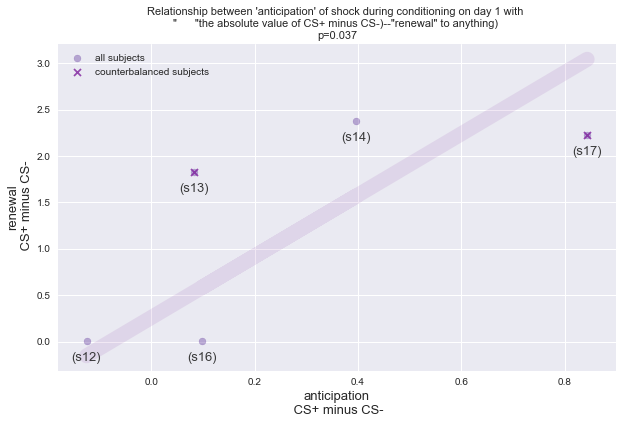

In [276]:
figure(figsize=(10,6))

iStim = 0
day2.nSeconds = 4.5
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');

var1 = mean(CSP - CSM,1)#[conditionedSubjects]
var2 =  abs(plus - minus) #plus[conditionedSubjects]-minus[conditionedSubjects]

tmp = smf.OLS(var2,var1).fit()

scatter(var1,var2,color='xkcd:indigo',alpha=.3,label='all subjects')
scatter(var1[cb],var2[cb],color='xkcd:purple',alpha=.8,marker='x',label='counterbalanced subjects')

plot(var1, tmp.predict(var1) + mean(var1), color='xkcd:purple',linewidth=15,alpha=.1)

legend()
xlabel('anticipation\n CS+ minus CS-',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title('Relationship between \'anticipation\' of shock during conditioning on day 1 with \n"\
      "the absolute value of CS+ minus CS-)--"renewal" to anything) \np=%.3f'%(tmp.pvalues),fontsize=11); 

for i_subject in range(day2.nSubjects): 
    plt.annotate('(%s)'%day2.subjectNames[i_subject][0:3], xy=(var1[i_subject], var2[i_subject]), 
                 textcoords='offset points', xytext=(-15, -20), alpha=.9, fontsize=13)

In [258]:
# CREATE A DATA FRAME FOR PHYSIO 

# response to first US
iStim = 3
USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = USplus - USminus

# last stimulus from extinction
iStim = 20
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
# renewal on day 2
renewal = (plus - minus) - (plus_end - minus_end)

# difference across conditioning
difference = mean(CSP - CSM,1) #difference = log(1 + difference)

# take counterbalanced subjects
order = np.zeros(len(plus))
order[cb] = 1 

# create data frame
SCR = pandas.DataFrame({'renewal':renewal,'prediction':difference,'US':US,'order':order})

In [259]:
formula = 'renewal ~ prediction'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

               sum_sq   df         F    PR(>F)
prediction   6.506803  1.0  1.092264  0.372765
Residual    17.871514  3.0       NaN       NaN


In [260]:
formula = 'renewal ~ US + prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

               sum_sq   df         F    PR(>F)
C(order)    15.730241  1.0  7.641445  0.220975
US           2.465910  1.0  1.197891  0.471302
prediction   0.102506  1.0  0.049795  0.860229
Residual     2.058543  1.0       NaN       NaN


In [261]:
physio = pandas.DataFrame() 
#physio['firstMinusLast'] = ( plusRen - minusRen ) - (plusEnd - minusEnd)
physio['renewal'] = renewal
physio['prediction'] = mean(log(1+CSP)- log(1+CSM),1)
#physio['resonance'] = resonance
physio['US'] = US

#physioTitleNames = ['firstMinusLast','renewal','prediction','US','resonance','meanSurprise']
physioTitleNames = ['renewal','prediction','first US']

renewalPredictionCorr = physio['renewal'].corr(physio['prediction'])
physio.corr()

,renewal,prediction,US
renewal,1.000000,-0.543143,-0.060971
prediction,-0.543143,1.000000,0.211056
US,-0.060971,0.211056,1.000000


In [254]:
p_value = .1
c_subs = find(conResults < p_value)

# response to first US
iStim = 3
USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = USplus[c_subs] - USminus[c_subs]

# last stimulus from extinction
iStim = 20
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
# renewal on day 2
renewal = (plus[c_subs] - minus[c_subs]) - (plus_end[c_subs] - minus_end[c_subs])

# difference across conditioning
difference = mean(CSP[c_subs] - CSM[c_subs],1) #difference = log(1 + difference)

# take counterbalanced subjects
order = np.zeros(len(plus))
order[cb] = 1 
order = order[c_subs]

# create data frame
SCR = pandas.DataFrame({'renewal':renewal,'prediction':difference,'US':US,'order':order})

In [256]:
# # formula = 'renewal ~ prediction'
# # model = ols(formula, SCR).fit()
# # aov_table = anova_lm(model, typ=2)
# # print(aov_table)

# print ('\n\n')
# formula = 'renewal ~ US + prediction'#+ C(order)'
# model = ols(formula, SCR).fit()
# aov_table = anova_lm(model, typ=2)
# print(aov_table)

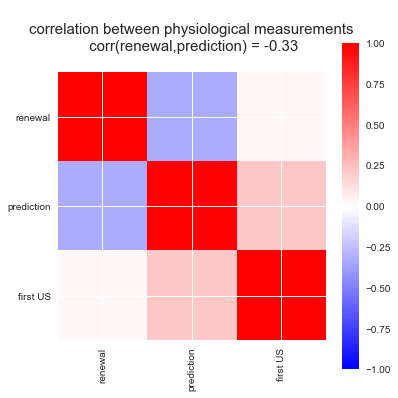

In [150]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([6,6])
ax = imshow(physio.corr())
ax1.set_xticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_xticklabels(physioTitleNames,rotation=90,fontsize=10); 
ax1.set_yticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_yticklabels(physioTitleNames,fontsize=10); 
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
title('\ncorrelation between physiological measurements\n corr(renewal,prediction) = %.2f\n'%
      (renewalPredictionCorr),fontsize=15); 
colorbar()

In [70]:
import behavioral_analysis_functions as ba_fun
self_report, subject_names = ba_fun.generate_data_frame()
ba_fun.correlation_matrix(self_report)

ImportError: No module named behavioral_analysis_functions

In [ ]:
SCR.index = day2.subjectNames
count = 0
for isubject in range(0, len(SCR)):
    if self_report.index[count] in SCR.index[isubject]: 
        for ikey in self_report.keys():
            SCR.loc[SCR.index[isubject], ikey] =  self_report.loc[self_report.index[count], ikey]
        count = count + 1 
    else: 
        pass

In [ ]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([10,10])
ax = plt.imshow(SCR.corr())
title_names = list(SCR.corr().keys())
ax1.set_xticks(np.array(list(range(0,len(title_names)))))
ax1.set_xticklabels(title_names,rotation=70);
ax1.set_yticks(np.array(list(range(0,len(title_names)))))
ax1.set_yticklabels(title_names);
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
plt.title('correlation between self report measures\n');
#plt.colorbar()
plt.show()

In [ ]:
formula = 'renewal ~ prediction + correctColor'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)